### **Waste Garbage Classification Using  Pre-train VGG - 16 Using Transfer Learning and Fine Tuning**

The difference between Transfer Learning and Fine-Tuning is that

* In Transfer Learning, we only optimize the weights of the new classification layers we have added, while we keep the weights of the original VGG16 model.

* In Fine-Tuning we optimize both the weights of the new classification layers we have added, as well as some or all of the layers from the VGG16 model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image as im
import cv2

In [4]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [5]:
BATCH_SIZE = 64
img_height = 244
img_width = 244

# **Load Datasets**

In [7]:
import os
data_path = '/content/drive/MyDrive/Garbage Dataset/Waste Garbage Datasets'
os.listdir(data_path)

['Waste_Garbage_Collection_improve.ipynb',
 'test-20231021T141615Z-001.zip',
 'train-20231021T141706Z-001.zip',
 'test',
 'train']

In [8]:
input_path = data_path
train_data_dir = input_path + '/' + 'train'
test_data_dir = input_path + '/' + 'test'

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2187 files belonging to 7 classes.
Using 1750 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 2187 files belonging to 7 classes.
Using 437 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


# **DataSets Visualizations**

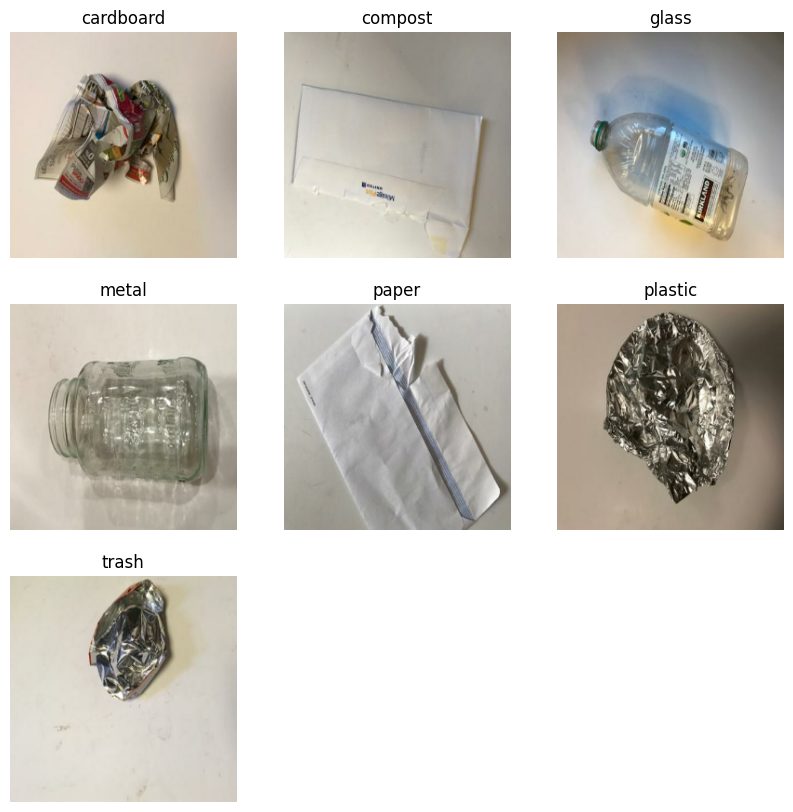

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

In [13]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

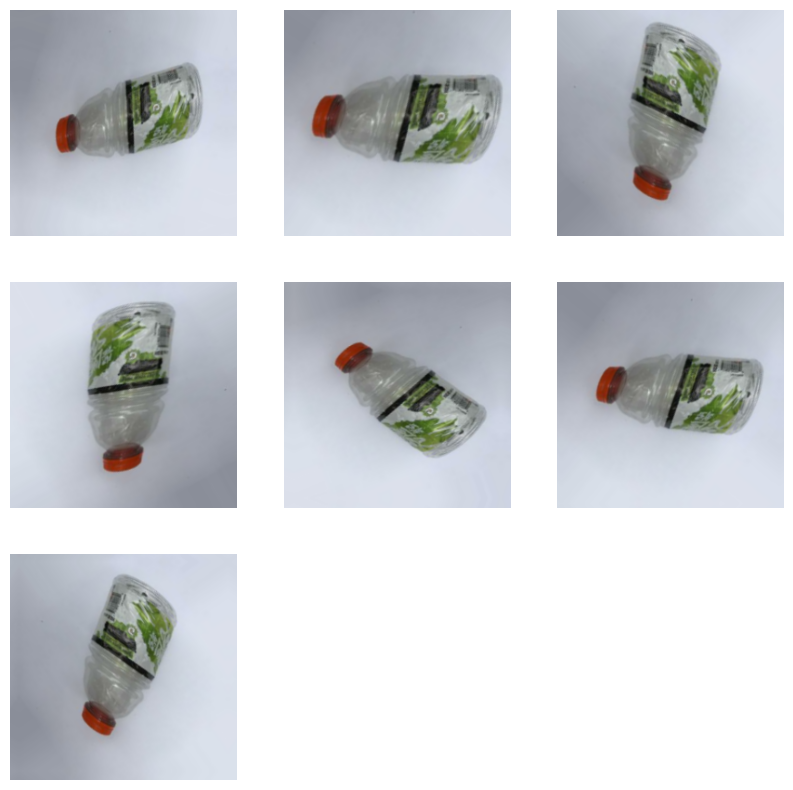

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [93]:
print(os.listdir(train_data_dir))

['plastic', 'paper', 'metal', 'cardboard', 'compost', 'trash', 'glass']


Text(0, 0.5, 'Number of Training images')

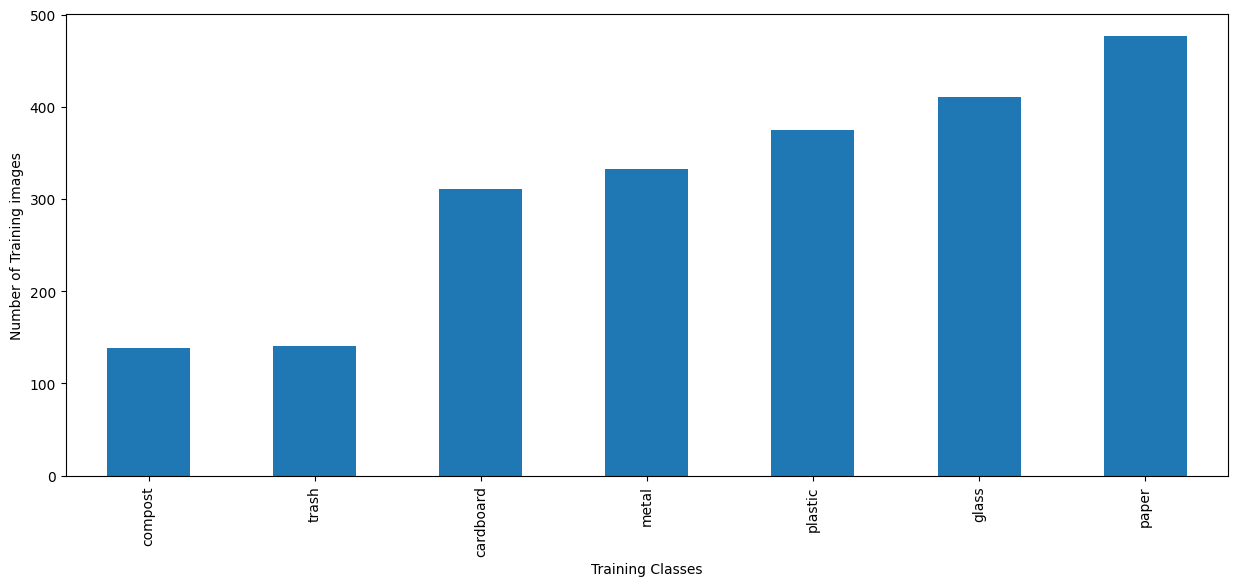

In [95]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(train_data_dir):
    data_dic[folder] = len(os.listdir(train_data_dir + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Training images')

Text(0, 0.5, 'Number of Testing images')

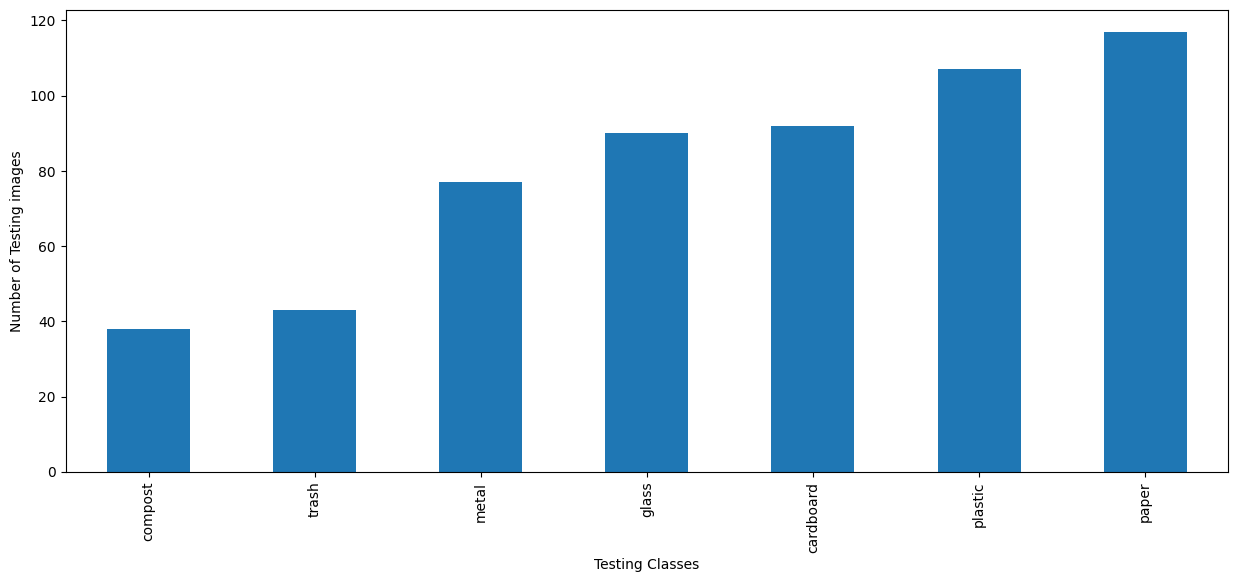

In [96]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(test_data_dir):
    data_dic[folder] = len(os.listdir(test_data_dir + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Testing images')

In [97]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **Model Architecture**

*   **VGG-16 Base Model**







In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                              

In [17]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [18]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


**Fix the weights**

In [19]:
base_model.trainable = False

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [22]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

### **Transfer Learning**







In [60]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

In [61]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [104]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [105]:
%%time
history = model.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 1.2858 - accuracy: 0.6697

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 18s 648ms/step - loss: 1.2858 - accuracy: 0.6697 - val_loss: 1.0226 - val_accuracy: 0.6705 - lr: 2.5000e-04
Epoch 2/20
28/28 [==============================] - 17s 597ms/step - loss: 0.6506 - accuracy: 0.7617 - val_loss: 1.0243 - val_accuracy: 0.6911 - lr: 2.5000e-04
Epoch 3/20
28/28 [==============================] - 16s 592ms/step - loss: 0.5827 - accuracy: 0.8109 - val_loss: 0.8392 - val_accuracy: 0.7300 - lr: 2.5000e-04
Epoch 4/20
28/28 [==============================] - 16s 587ms/step - loss: 0.4847 - accuracy: 0.8280 - val_loss: 0.8388 - val_accuracy: 0.7574 - lr: 2.5000e-04
Epoch 5/20
28/28 [==============================] - 15s 551ms/step - loss: 0.4169 - accuracy: 0.8583 - val_loss: 0.8426 - val_accuracy: 0.7643 - lr: 2.5000e-04
Epoch 6/20
28/28 [==============================] - 17s 595ms/step - loss: 0.3972 - accuracy: 0.8640 - val_loss: 0.7344 - val_accuracy: 0.7849 - lr: 2.5000e-04
Epoch 7/20
28/28 [==============================] -

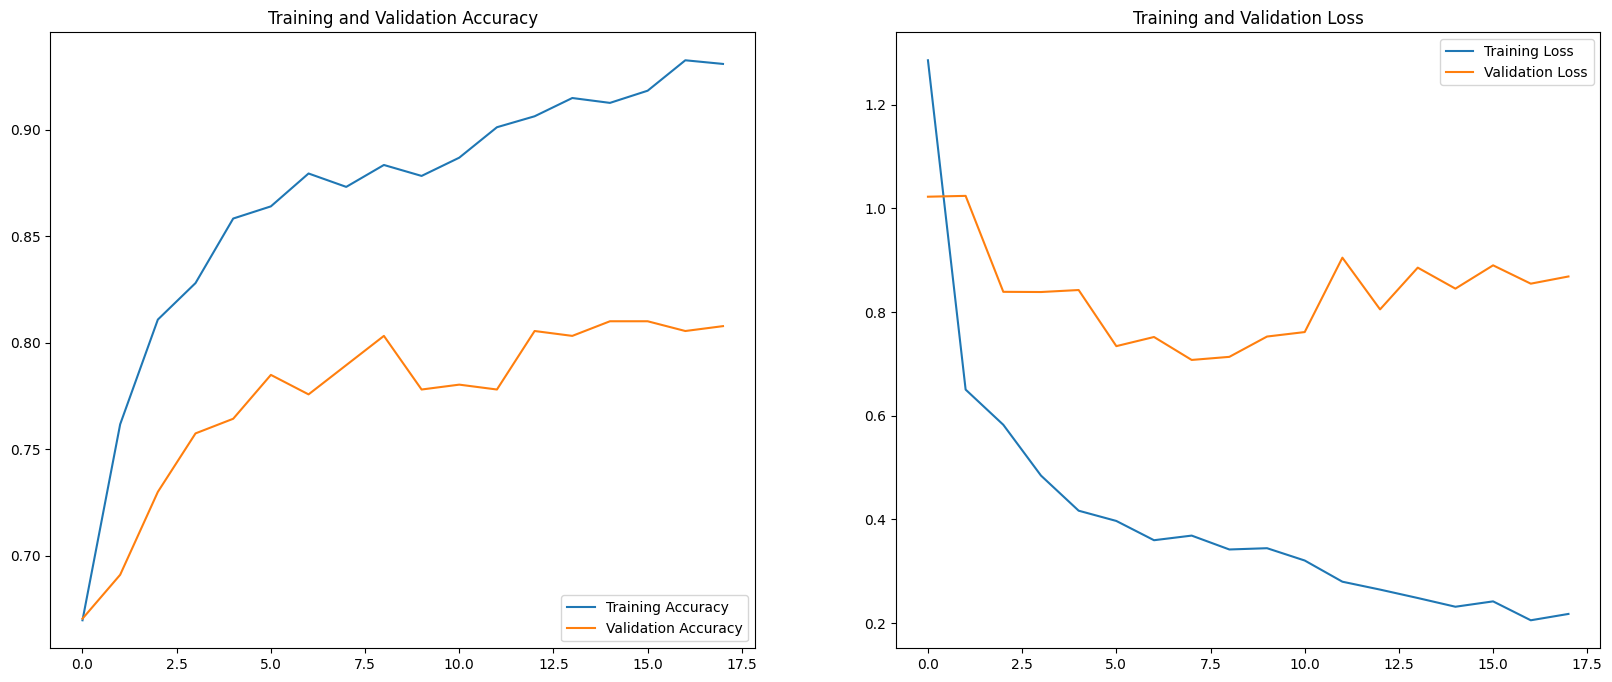

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(18)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [108]:
# Generate predictions
model.load_weights('/content/vgg16_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

564/564 [==============================] - 6s 10ms/step


In [109]:
loss, accuracy = model.evaluate(test_ds, verbose = 1)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

564/564 [==============================] - 6s 11ms/step - loss: 0.8659 - accuracy: 0.7677
Loss :  0.8658645153045654
Accuracy :  0.7677304744720459


In [110]:
print(pred_classes)

[5 3 3 4 5 0 0 4 0 4 2 4 0 3 2 2 6 2 5 4 6 3 3 5 5 0 5 0 0 0 4 2 2 5 4 3 5
 5 0 0 2 5 0 3 5 0 3 4 3 4 3 3 2 6 0 2 3 5 2 1 2 3 4 5 5 0 6 5 4 4 6 2 3 3
 3 0 0 5 2 4 2 3 3 5 3 1 4 6 2 2 2 2 5 2 5 6 5 5 0 5 4 5 3 5 4 2 4 2 6 0 6
 4 3 4 4 0 4 4 0 4 3 3 5 3 2 0 5 4 4 4 2 0 5 4 5 4 0 2 4 2 0 6 4 1 4 3 4 6
 2 0 4 5 5 2 4 3 4 0 1 2 2 5 4 3 3 3 3 0 4 6 0 5 3 6 2 1 1 5 3 4 0 0 0 3 3
 5 1 4 2 4 5 2 5 3 5 0 4 2 3 5 5 5 3 2 3 0 3 4 3 0 6 6 0 5 4 5 3 6 5 4 3 1
 5 0 1 3 6 2 0 3 5 4 2 3 5 4 6 6 3 3 0 3 6 3 3 0 3 0 6 1 4 4 0 4 4 4 4 2 1
 3 0 0 2 4 4 0 0 3 4 4 5 5 0 2 5 5 4 0 5 0 4 0 4 0 2 4 4 0 5 3 0 0 3 5 3 3
 6 2 0 1 0 0 2 1 2 1 2 0 0 4 4 1 0 0 3 0 3 2 3 3 0 4 3 4 4 5 5 3 4 5 3 5 6
 4 5 4 5 5 4 3 2 4 4 0 3 1 4 3 2 4 4 4 2 2 0 6 4 4 4 6 2 5 5 3 3 4 1 2 0 3
 4 5 6 2 2 5 4 5 4 4 0 3 5 1 2 6 0 5 2 5 5 0 3 0 5 3 3 3 4 3 2 0 3 0 0 4 5
 3 0 0 3 3 1 4 1 5 6 3 0 4 5 4 4 0 4 5 0 3 4 4 4 4 5 3 5 4 6 3 4 4 2 3 4 4
 4 4 0 5 0 6 4 4 0 4 2 3 3 4 4 4 0 4 1 2 2 3 2 3 3 0 0 6 5 4 4 3 2 3 0 3 5
 5 0 1 0 4 5 4 5 4 0 4 3 

# **Fine Tuning**

In [111]:
fine_tune  = base_model

In [112]:
fine_tune.trainable = True

In [113]:
for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)

    # Set the layer's bool.
    layer.trainable = trainable

In [114]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [115]:
fine_tune.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [116]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [117]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 244, 244, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [118]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [119]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [120]:
%%time
history = model2.fit(train_ds,
                    epochs = 25,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/25
28/28 [==============================] - ETA: 0s - loss: 1.1306 - accuracy: 0.6131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 20s 606ms/step - loss: 1.1306 - accuracy: 0.6131 - val_loss: 0.9214 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 2/25
28/28 [==============================] - 17s 621ms/step - loss: 0.6640 - accuracy: 0.7909 - val_loss: 0.8277 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 3/25
28/28 [==============================] - 16s 562ms/step - loss: 0.5826 - accuracy: 0.8166 - val_loss: 0.8508 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 4/25
28/28 [==============================] - 16s 559ms/step - loss: 0.4860 - accuracy: 0.8360 - val_loss: 1.0324 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 5/25
28/28 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.8217
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 [==============================] - 16s 562ms/step - loss: 0.5364 - accuracy: 0.8217 - val_loss: 0.8467 - val_accuracy: 0.7529 - lr: 0.0010
Epoch 6/25
28/28 [==============================] - 17s 595ms/step - los

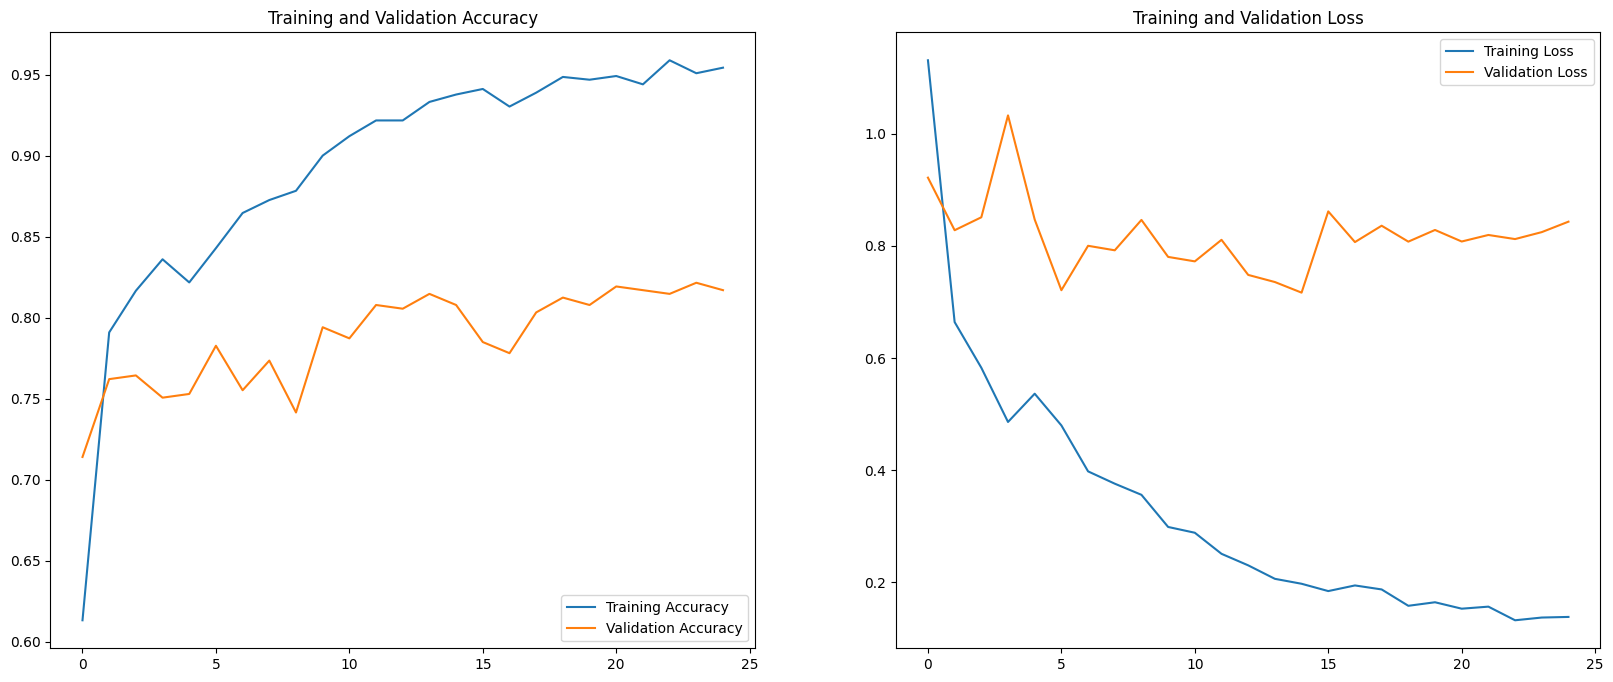

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [122]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 564 files belonging to 7 classes.


In [123]:
# Generate predictions
model2.load_weights('/content/vgg16_best_weights_fine_tuning.hdf5') # initialize the best trained weights
preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

564/564 [==============================] - 6s 10ms/step


In [124]:
loss, accuracy = model2.evaluate(test_ds, verbose = 1)
print("Loss : ",loss)
print("Accuracy : ",accuracy)

564/564 [==============================] - 6s 11ms/step - loss: 0.7996 - accuracy: 0.8032
Loss :  0.7996399998664856
Accuracy :  0.8031914830207825


In [125]:
print(pred_classes)

[5 2 3 4 5 0 0 4 0 4 2 4 0 3 2 2 2 2 5 4 6 3 4 5 5 0 5 0 0 0 4 2 2 5 4 3 5
 5 0 0 2 5 0 3 5 0 3 4 3 4 3 4 2 6 0 2 3 5 2 1 2 5 4 0 5 0 6 5 5 4 6 2 3 3
 3 0 0 5 2 4 3 4 3 5 3 1 6 6 2 2 2 5 6 2 5 6 5 5 0 5 4 5 3 5 4 2 4 2 6 0 6
 4 3 4 4 0 4 4 0 4 3 3 6 3 2 0 2 4 4 4 2 0 5 4 5 4 0 2 4 2 0 6 4 1 4 3 4 6
 5 0 4 5 5 2 4 3 5 0 1 2 2 0 4 2 3 3 3 0 4 6 0 5 3 4 2 6 1 5 3 4 0 4 0 3 3
 5 1 4 2 4 2 2 5 3 5 0 4 2 3 5 2 5 6 2 3 0 2 6 3 0 6 6 0 5 4 5 3 6 5 4 3 1
 5 4 1 3 6 2 0 3 5 4 2 3 5 4 6 6 3 3 4 2 6 2 3 0 3 0 6 1 4 4 0 6 4 4 4 2 1
 2 0 3 2 4 4 0 0 2 4 4 5 5 0 5 5 6 4 0 5 0 4 0 4 0 2 4 4 0 5 3 0 0 3 6 3 2
 6 5 0 1 0 0 2 1 2 1 2 0 0 4 4 1 0 0 3 0 2 2 3 3 6 4 3 4 4 5 5 3 4 5 2 5 6
 4 5 4 5 6 4 3 2 4 4 0 6 1 4 2 2 4 4 2 2 2 0 6 4 4 4 6 2 5 5 3 3 4 1 2 0 5
 4 5 6 2 2 5 4 6 4 4 0 2 5 1 2 6 0 5 2 5 5 0 3 0 6 3 3 3 6 6 2 0 2 0 0 4 5
 3 0 0 3 3 1 4 1 5 6 2 0 4 6 4 4 0 4 2 0 4 4 4 4 4 5 3 5 2 6 3 4 4 2 3 4 4
 4 0 0 6 0 6 4 4 0 4 2 5 2 6 4 4 0 4 1 2 2 3 3 3 3 0 0 6 5 4 4 3 2 3 0 3 5
 5 0 1 0 4 5 4 5 4 0 4 3 

# **FINAL RESULTS**

**Accuracy On Transfer Learning : 76.7%** </br>
**Accuracy On Fine Tuning : 80.3%**</br>
